# 5 Year

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

2024-11-09 18:21:17.464111: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [64]:
df = pd.read_pickle('../data/df_22_23_cleaned.pkl') 

In [65]:
def day_flag(data):
    data['DayOfWeek'] = data.index.dayofweek              # Day of the week (0=Monday, 6=Sunday)
    data['WeekOfYear'] = data.index.isocalendar().week    # ISO week number of the year
    data['Day'] = data.index.day                          # Day of the month
    data['Month'] = data.index.month                      # Month of the year
    data['Year'] = data.index.year                        # Year
    data['PeriodOfDay'] = data.index.hour                 # Hour of the day (0-23)
    # Add cyclic transformations for HourOfDay and DayOfWeek
    data['HourOfDay_sin'] = np.sin(2 * np.pi * data['PeriodOfDay'] / 24)
    data['HourOfDay_cos'] = np.cos(2 * np.pi * data['PeriodOfDay'] / 24)
    
    data['DayOfWeek_sin'] = np.sin(2 * np.pi * data['DayOfWeek'] / 7)
    data['DayOfWeek_cos'] = np.cos(2 * np.pi * data['DayOfWeek'] / 7)
    
    # Drop original cyclic features if you want to avoid redundancy
    data.drop(['PeriodOfDay', 'DayOfWeek'], axis=1, inplace=True)

    return data

In [66]:
df = day_flag(df)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2019-01-01 01:00:00 to 2024-01-01 00:00:00
Freq: h
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          43824 non-null  float64
 1   solar          43824 non-null  int64  
 2   wind_onshore   43824 non-null  int64  
 3   wind_offshore  43824 non-null  int64  
 4   total_load     43824 non-null  int64  
 5   WeekOfYear     43824 non-null  UInt32 
 6   Day            43824 non-null  int32  
 7   Month          43824 non-null  int32  
 8   Year           43824 non-null  int32  
 9   HourOfDay_sin  43824 non-null  float64
 10  HourOfDay_cos  43824 non-null  float64
 11  DayOfWeek_sin  43824 non-null  float64
 12  DayOfWeek_cos  43824 non-null  float64
dtypes: UInt32(1), float64(5), int32(3), int64(4)
memory usage: 4.1 MB


In [68]:
# Create lagged features
df['price_t-1'] = df['price'].shift(1)
df['price_t-2'] = df['price'].shift(2)
df['price_t-25'] = df['price'].shift(25)

In [69]:
df = df.dropna()

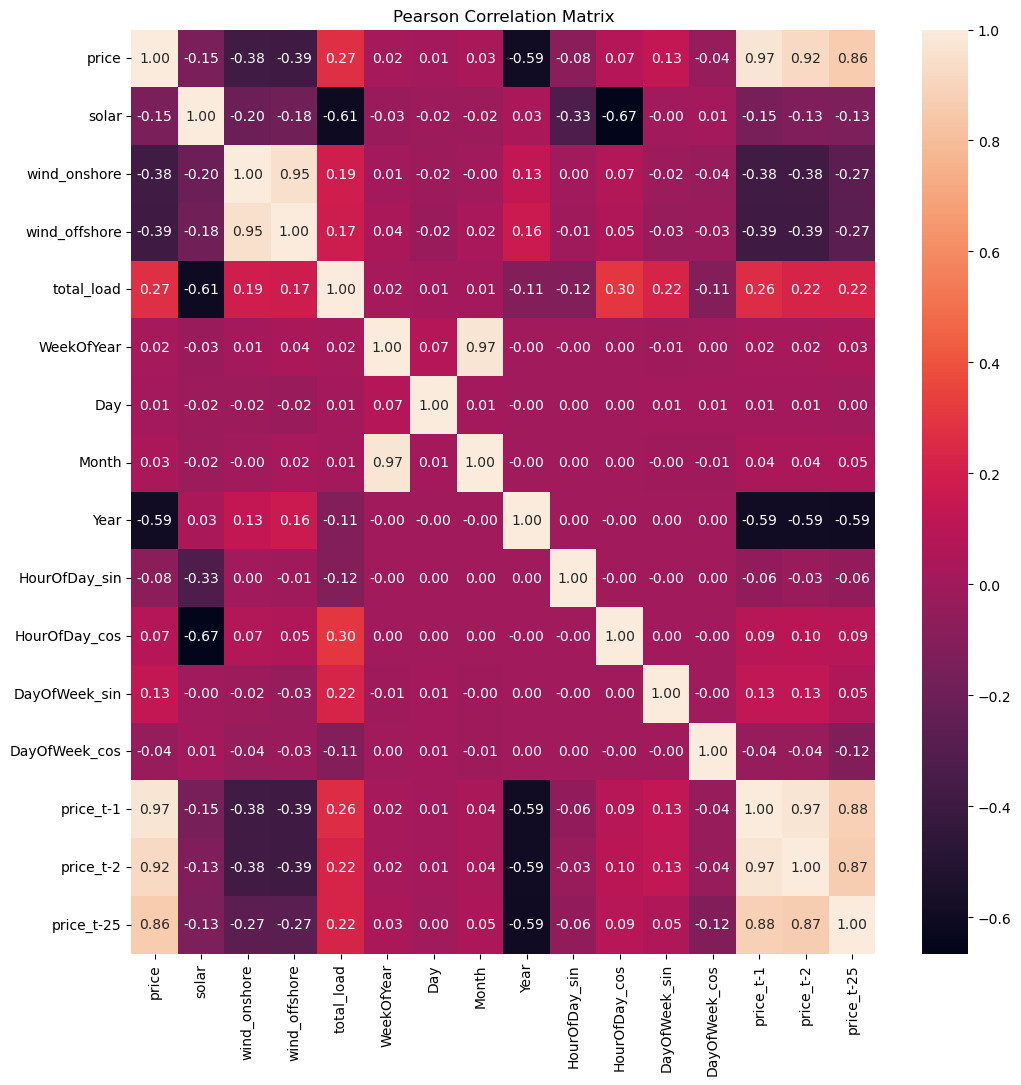

In [79]:
import seaborn as sns
correlations = df['2022':'2023'].corr(method='pearson')
fig = plt.figure(figsize=(12, 12))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()


In [45]:
# less is more
# df = data.drop(columns = ['wind_onshore', 'wind_offshore', 'solar', 'total_load'])
# features = df.columns.tolist()

# Assuming data is in a DataFrame called `df` with columns like 'price', 'wind', 'solar', 'total_load'
# and an hourly datetime index from 2018-01-01 to 2023-12-31
# Ensure 'price' is the target variable
# features = ['price', 'wind_onshore', 'wind_offshore', 'solar', 'total_load','HourOfDay_sin', 'HourOfDay_cos','DayOfWeek_sin','DayOfWeek_cos']  # Features + target
features = ['price', 'price_t-1', 'price_t-2', 'price_t-25']  # Features + target
df = df[features]

# Step 1: Data Preprocessing
# Splitting data into train (2018-2021), validation (2022), and test (2023)
train_df = df['2019':'2021']
val_df = df['2022': '2022']
test_df = df['2023': '2023']

# Step 2: Data Scaling

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df[features])
val_scaled = scaler.transform(val_df[features])
test_scaled = scaler.transform(test_df[features])

# Step 3: Create Sequences Function
def create_sequences_2(data, seq_length=24, target_column='price'):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length].values)  # Include all features in X
        y.append(data[target_column].iloc[i+seq_length])  # Target is still the original 'price'
    return np.array(X), np.array(y)

# Convert scaled data to DataFrame for consistency in `create_sequences` function
train_scaled_df = pd.DataFrame(train_scaled, columns=features)
val_scaled_df = pd.DataFrame(val_scaled, columns=features)
test_scaled_df = pd.DataFrame(test_scaled, columns=features)

# Generate sequences for LSTM model
X_train, y_train = create_sequences_2(train_scaled_df)
X_val, y_val = create_sequences_2(val_scaled_df)
X_test, y_test = create_sequences_2(test_scaled_df)

# Step 4: Build the LSTM Model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer for regression

model.compile(optimizer='adam', loss='mean_squared_error')

# Step 5: Train the Model with Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Step 6: Evaluate the Model on the Test Set
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Step 7: Make Predictions on the Test Set and Inverse Transform
y_pred = model.predict(X_test)

Epoch 1/50


/Users/libin/anaconda3/envs/th/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


821/821 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.0031 - val_loss: 0.0103
Epoch 2/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0011 - val_loss: 0.0064
Epoch 3/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 6.7748e-04 - val_loss: 0.0051
Epoch 4/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 5.4550e-04 - val_loss: 0.0031
Epoch 5/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 5.1919e-04 - val_loss: 0.0033
Epoch 6/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 4.6509e-04 - val_loss: 0.0040
Epoch 7/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 4.0839e-04 - val_loss: 0.0023
Epoch 8/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 4.3456e-04 - val_loss: 0.0029
Epoch 9/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 4.0441e-04 - val_loss: 0.0025
Epoch 10/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 3.9789e-04 - val_loss: 0.0031
Epoch 11/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 3.7631e-04 - val_loss: 0.0022
Epoch 

In [ ]:

# df = data.drop(columns = ['wind_onshore', 'wind_offshore', 'solar', 'total_load'])
# features = df.columns.tolist()

# Assuming data is in a DataFrame called `df` with columns like 'price', 'wind', 'solar', 'total_load'
# and an hourly datetime index from 2018-01-01 to 2023-12-31
# Ensure 'price' is the target variable
features = ['price', 'wind_onshore', 'wind_offshore', 'solar', 'total_load','HourOfDay_sin', 'HourOfDay_cos','DayOfWeek_sin','DayOfWeek_cos']  # Features + target
# features = ['price', 'price_t-1', 'price_t-2', 'price_t-25']  # Features + target
df = df[features]

# Step 1: Data Preprocessing
# Splitting data into train (2018-2021), validation (2022), and test (2023)
train_df = df['2019':'2021']
val_df = df['2022': '2022']
test_df = df['2023': '2023']

# Step 2: Data Scaling

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df[features])
val_scaled = scaler.transform(val_df[features])
test_scaled = scaler.transform(test_df[features])

# Step 3: Create Sequences Function
def create_sequences_2(data, seq_length=24, target_column='price'):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length].values)  # Include all features in X
        y.append(data[target_column].iloc[i+seq_length])  # Target is still the original 'price'
    return np.array(X), np.array(y)

# Convert scaled data to DataFrame for consistency in `create_sequences` function
train_scaled_df = pd.DataFrame(train_scaled, columns=features)
val_scaled_df = pd.DataFrame(val_scaled, columns=features)
test_scaled_df = pd.DataFrame(test_scaled, columns=features)

# Generate sequences for LSTM model
X_train, y_train = create_sequences_2(train_scaled_df)
X_val, y_val = create_sequences_2(val_scaled_df)
X_test, y_test = create_sequences_2(test_scaled_df)

# Step 4: Build the LSTM Model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer for regression

model.compile(optimizer='adam', loss='mean_squared_error')

# Step 5: Train the Model with Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Step 6: Evaluate the Model on the Test Set
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Step 7: Make Predictions on the Test Set and Inverse Transform
y_pred = model.predict(X_test)

In [ ]:
# 0.0008918565581552684
# 15ms/step - loss: 2.8214e-04 - val_loss: 0.0044

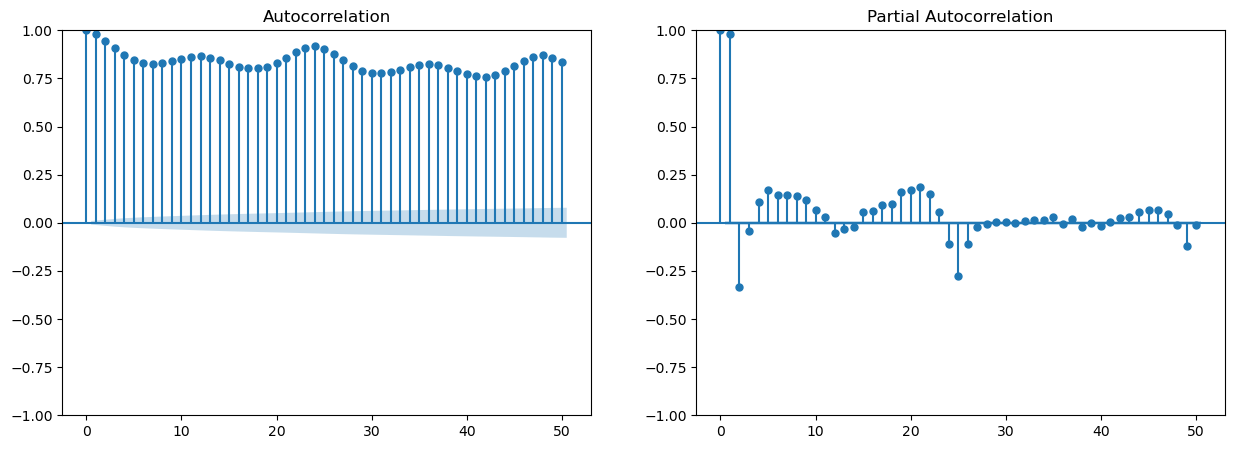

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming df has a datetime index and 'value' is the target column
y = df['price']

# Plot ACF and PACF for weekly lags
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(y, lags=50, ax=axes[0])  # ACF up to 1 week (168 hours)
plot_pacf(y, lags=50, ax=axes[1])  # PACF up to 1 week (168 hours)
plt.show()

In [24]:
# Test Loss: 0.003127522300928831
# Test Loss: 0.001149863237515092

In [46]:
# pred_a = scaler.inverse_transform(y_pred)[:, 0]
pred_actual = scaler.inverse_transform(
    np.concatenate((y_pred, X_test[:, -1, 1:]), axis=1))[:, 0]
# test_a = scaler.inverse_transform(
    # np.concatenate((y_test.reshape(-1, 1), X_test[:, -1, 1:]), axis=1))[:, 0]
y_test_actual = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1, 1), X_test[:, -1, 1:]), axis=1))[:, 0]

In [47]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Calculate MAE
mae = mean_absolute_error(y_test_actual, pred_actual)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_actual, pred_actual))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
               
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))


smape_value = smape(y_test_actual, pred_actual)
print(f"Symmetric Mean Absolute Percentage Error (sMAPE): {smape_value:.2f}")

Mean Absolute Error (MAE): 10.62
Root Mean Squared Error (RMSE): 17.36
Symmetric Mean Absolute Percentage Error (sMAPE): 22.18


In [49]:
import seaborn as sns

<Axes: >

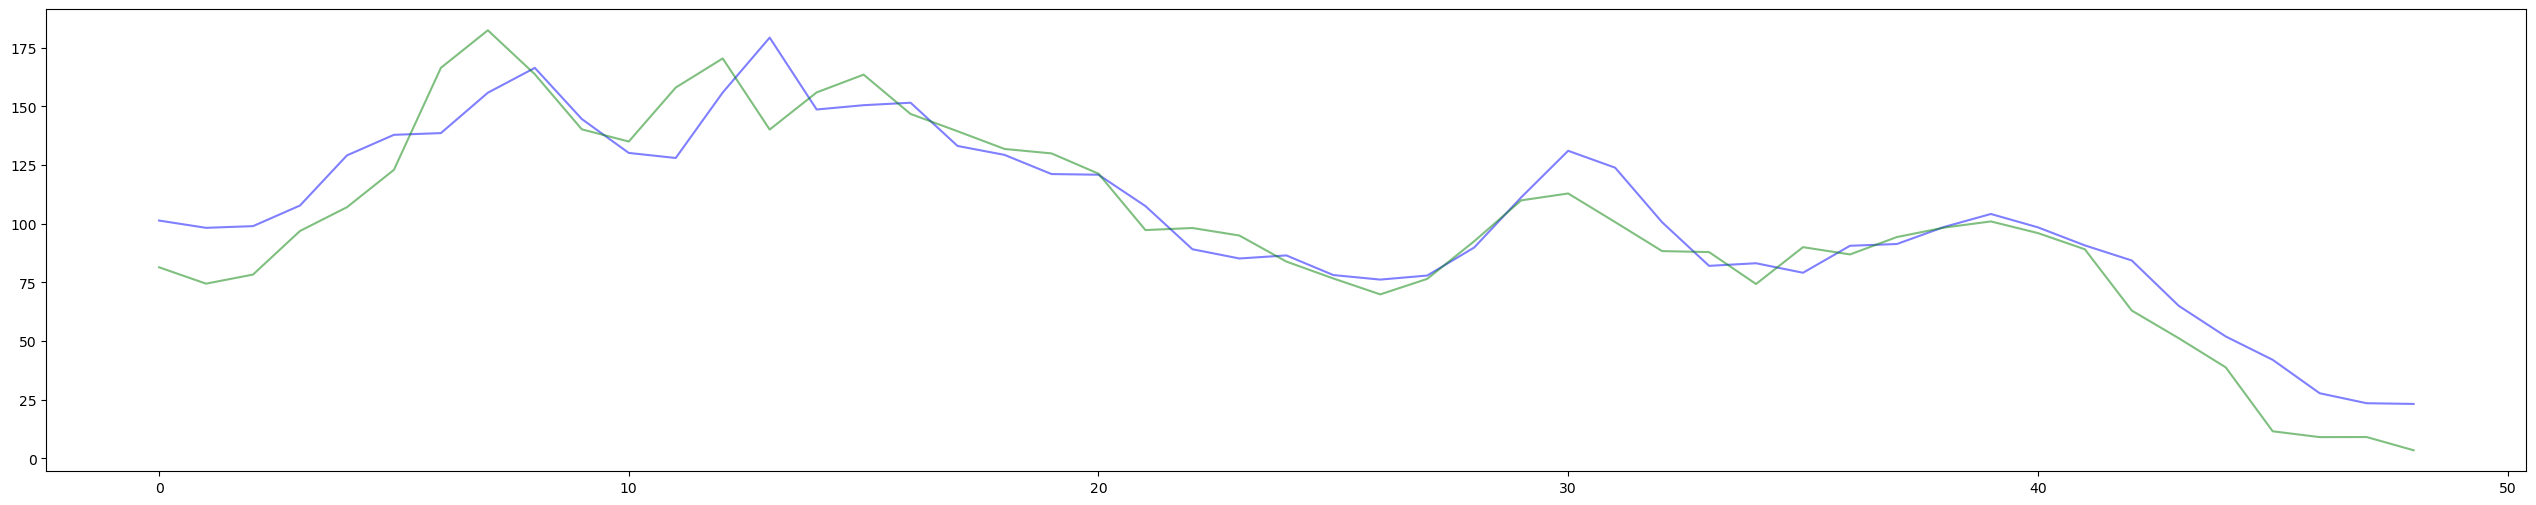

In [62]:
# fig, axes = plt.subplots(figsize=(32, 6))
# sns.lineplot(pred_actual[100:149], c = 'blue', alpha = 0.5)
# sns.lineplot(y_test_actual[100:149], c = 'green', alpha = 0.5)

In [10]:
yt, p = y_test_actual, pred_actual

In [ ]:
# Mean Absolute Error (MAE): 19.70
# Root Mean Squared Error (RMSE): 26.91
# Symmetric Mean Absolute Percentage Error (sMAPE): 30.41

# add day flag
# Mean Absolute Error (MAE): 58.58
# Root Mean Squared Error (RMSE): 71.37
# Symmetric Mean Absolute Percentage Error (sMAPE): 55.08


# Mean Absolute Error (MAE): 11.67
# Root Mean Squared Error (RMSE): 17.85
# Symmetric Mean Absolute Percentage Error (sMAPE): 21.34

# Mean Absolute Error (MAE): 16.61
# Root Mean Squared Error (RMSE): 23.14
# Symmetric Mean Absolute Percentage Error (sMAPE): 26.56


# Mean Absolute Error (MAE): 11.29
# Root Mean Squared Error (RMSE): 20.78
# Symmetric Mean Absolute Percentage Error (sMAPE): 22.56

### record:

- without energy generation feature

Mean Absolute Error (MAE): 39.45

Root Mean Squared Error (RMSE): 48.36

Symmetric Mean Absolute Percentage Error (sMAPE): 44.59

-  Without day flag 

Mean Absolute Error (MAE): 16.14

Root Mean Squared Error (RMSE): 23.02

Symmetric Mean Absolute Percentage Error (sMAPE): 26.63

- With day flag

Mean Absolute Error (MAE): 13.45

Root Mean Squared Error (RMSE): 19.80

Symmetric Mean Absolute Percentage Error (sMAPE): 23.07

# importance

In [113]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Get baseline performance
baseline_predictions = model.predict(X_test)
baseline_mse = mean_squared_error(y_test, baseline_predictions)

# Shuffle 'wind_onshore' in X_test
X_test_permuted = X_test.copy()
wind_onshore_index = features.index('wind_onshore')
np.random.shuffle(X_test_permuted[:, :, wind_onshore_index])  # Shuffle along the feature dimension

# Evaluate with permuted 'wind_onshore'
permuted_predictions = model.predict(X_test_permuted)
permuted_mse = mean_squared_error(y_test, permuted_predictions)

# Calculate the importance
importance = permuted_mse - baseline_mse
print(f"Importance of 'wind_onshore': {importance}")


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Importance of 'wind_onshore': 0.00017517197860684964


## feature selection

In [80]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd

In [82]:
# Assuming 'df' is your DataFrame, 'price' is the target, and other columns are features
X = df.drop(columns=['price'])
y = df['price']

# Compute mutual information scores
mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
print(mi_scores)

price_t-1        1.800129
price_t-2        1.279059
price_t-25       1.004123
Year             0.652969
WeekOfYear       0.256088
Month            0.164406
total_load       0.140937
wind_offshore    0.138023
wind_onshore     0.073278
solar            0.061734
Day              0.046388
DayOfWeek_sin    0.032143
HourOfDay_sin    0.032122
DayOfWeek_cos    0.015883
HourOfDay_cos    0.015482
dtype: float64


In [88]:
from statsmodels.tsa.stattools import grangercausalitytests

# Granger causality test to see if lagged 'price' values predict future 'price' values
grangercausalitytests(df[['price', 'onshore']].dropna(), maxlag=7)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=306.5480, p=0.0000  , df_denom=43795, df_num=1
ssr based chi2 test:   chi2=306.5690, p=0.0000  , df=1
likelihood ratio test: chi2=305.5010, p=0.0000  , df=1
parameter F test:         F=306.5480, p=0.0000  , df_denom=43795, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1348.0146, p=0.0000  , df_denom=43792, df_num=2
ssr based chi2 test:   chi2=2696.3371, p=0.0000  , df=2
likelihood ratio test: chi2=2616.5945, p=0.0000  , df=2
parameter F test:         F=1348.0146, p=0.0000  , df_denom=43792, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=997.9598, p=0.0000  , df_denom=43789, df_num=3
ssr based chi2 test:   chi2=2994.3579, p=0.0000  , df=3
likelihood ratio test: chi2=2896.4338, p=0.0000  , df=3
parameter F test:         F=997.9598, p=0.0000  , df_denom=43789, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=71

{1: ({'ssr_ftest': (306.54799129245873, 2.111708551179317e-68, 43795.0, 1),
   'ssr_chi2test': (306.5689901273458, 1.2208444243605795e-68, 1),
   'lrtest': (305.50103879347444, 2.0860076777103726e-68, 1),
   'params_ftest': (306.54799129244225, 2.1117085511948017e-68, 43795.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1348.0146298491586, 0.0, 43792.0, 2),
   'ssr_chi2test': (2696.337081818761, 0.0, 2),
   'lrtest': (2616.594473160396, 0.0, 2),
   'params_ftest': (1348.014629849213, 0.0, 43792.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (997.9597834602616, 0.0, 43789.0, 3),
   'ssr_chi2test': (2994.357944444423, 0.0, 3),
   'lrtest': (2896.4338259112556, 0.0, 3),
   'params_ftest': (997.95978346023, 0.0, 43789.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])]),
 4: ({'ssr_ftest': (718.2319247309227, 0.0, 43786.0, 4),
   'ssr_chi2test': (2873